In [94]:
import json

# Load the dataset
with open('primate_dataset.json', 'r') as file:
    data = json.load(file)

# Example of accessing a post and its annotations
print(data[0]['post_text'])
print(data[0]['annotations'])


When I was in high school a few years back, I was one of the highest competitors in my school. I joined the high school band in freshman year and by senior year I became one of the best in my section. My academics were always straight and I exercised daily. Senior year I enlisted in the military and now I believe it was one of my worst decisions in life. Before I went to boot camp I was motivated, a patriot and believed that the elite joined the military. In senior year I never applied for any scholarships and I was offered one but turned it down because I already signed the papers. I thought I set myself up for success. Now I believe I was dead wrong for joining. The only benefit I see so far after a year and a half of service is that I'm trying to set myself up financially before I get out and hopefully attend college. It sounds like a plan but I feel no happiness from what I do at all. I convinced myself there's no honor in it anymore, it's just another job. I don't exercise by myse

In [95]:
from nltk import word_tokenize
import re
from nltk.corpus import stopwords
import pandas as pd

# Define a function to preprocess the text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join the tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text
processed_data = [preprocess_text(item['post_text']) for item in data]
for item, processed_text in zip(data, processed_data):
    item['processed_post_text'] = processed_text


In [96]:
data[0]['processed_post_text']

'high school years back one highest competitors school joined high school band freshman year senior year became one best section academics always straight exercised daily senior year enlisted military believe one worst decisions life went boot camp motivated patriot believed elite joined military senior year never applied scholarships offered one turned already signed papers thought set success believe dead wrong joining benefit see far year half service trying set financially get hopefully attend college sounds like plan feel happiness convinced honor anymore another job exercise anymore feel like progressing anywhere life service body somebody else exact replaceable mindset military gave look forward going back home months vacation thing looking forward since stationed thing eyes getting service going home closer family nothing satisfies hate feel like tried everything happy seems impossible wish somebody could help'

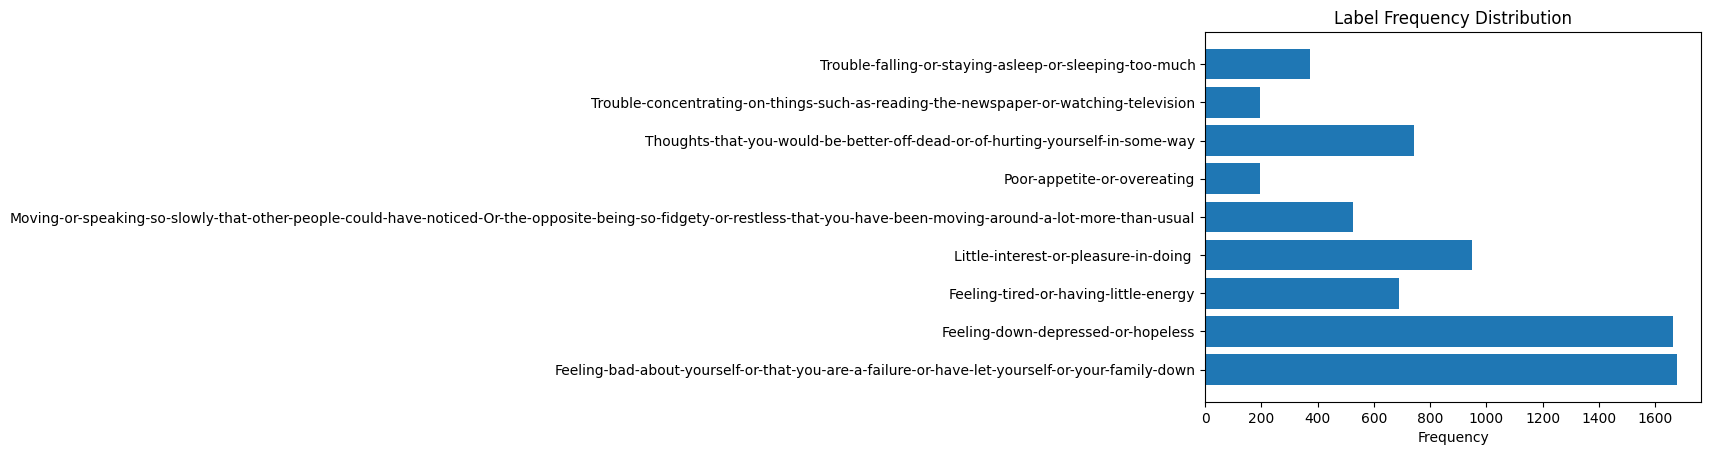

In [97]:
from collections import Counter

# Aggregate labels to count occurrences
label_counts = Counter()
for item in data:
    for annotation in item['annotations']:
        label_counts[annotation[0]] += 1 if annotation[1] == "yes" else 0

# Plotting
import matplotlib.pyplot as plt

labels, counts = zip(*label_counts.items())
plt.barh(labels, counts)
plt.xlabel('Frequency')
plt.title('Label Frequency Distribution')
plt.show()


In [98]:
from sklearn.preprocessing import MultiLabelBinarizer

# Prepare labels for multi-label binarization
all_labels = [tuple(ann[0] for ann in item['annotations'] if ann[1] == "yes") for item in data]

mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(all_labels)

# Now `encoded_labels` can be used for model training


In [99]:
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights
sample_weights = compute_sample_weight('balanced', encoded_labels)

# Sample weights can be passed during model training to handle class imbalance


In [100]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizing text data
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform([item['processed_post_text'] for item in data]).toarray()

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)


In [101]:
sample_weights = sample_weights[:-401]
sample_weights.shape

(1602,)

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
validation_accuracy = []
for epoch in range(10):
    # Train the model
    model.fit(X_train, y_train, epochs=1, batch_size=32, sample_weight=sample_weights)
    
    # Evaluate the model on the validation set
    loss, accuracy = model.evaluate(X_test, y_test)
    
    # Append the validation accuracy to the list
    validation_accuracy.append(accuracy)

# Evaluate the model
model.evaluate(X_test, y_test)


13/13 [==============================] - 0s 3ms/step - loss: 0.5081 - accuracy: 0.8429


[0.5081000328063965, 0.8428927659988403]

In [103]:
print(validation_accuracy)

[0.8428927659988403, 0.8428927659988403, 0.8428927659988403, 0.8428927659988403, 0.8428927659988403, 0.8428927659988403, 0.8428927659988403, 0.8428927659988403, 0.8428927659988403, 0.8428927659988403]


In [104]:
y_pred = model.predict(X_test)
y_pred.shape

13/13 [==============================] - 0s 1ms/step


(401, 9)

In [105]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np
# Compute the ROC curve for each label separately
fpr = dict()
tpr = dict()
roc_auc = dict()
optimal_thresholds = dict()

for i in range(y_test.shape[1]):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    # Find the optimal threshold for each label
    optimal_thresholds[i] = thresholds[np.argmax(tpr[i] - fpr[i])]
optimal_threshold = np.mean(list(optimal_thresholds.values()))
print("Optimal Thresholds:", optimal_threshold)


Optimal Thresholds: 0.40821147


In [106]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Predict on test set
y_pred = model.predict(X_test)

# Convert predictions to binary (you may need to adjust the threshold)
y_pred_bin = (y_pred > optimal_threshold).astype(int)

# Classification report
print(classification_report(y_test, y_pred_bin, target_names=mlb.classes_, zero_division=1))




13/13 [==============================] - 0s 2ms/step


                                                                                                                                                                       precision    recall  f1-score   support

                                                                        Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down       0.84      1.00      0.91       338
                                                                                                                                   Feeling-down-depressed-or-hopeless       0.82      1.00      0.90       329
                                                                                                                                Feeling-tired-or-having-little-energy       0.47      0.21      0.29       148
                                                                                                                                Little-interest-or-pleasure-in-doing       

In [107]:
# Calculate ROC AUC for each label
roc_auc_scores = {label: roc_auc_score(y_test[:, i], y_pred[:, i]) for i, label in enumerate(mlb.classes_)}
print(roc_auc_scores)

{'Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down': 0.5266741805203344, 'Feeling-down-depressed-or-hopeless': 0.682033096926714, 'Feeling-tired-or-having-little-energy': 0.5737901933554108, 'Little-interest-or-pleasure-in-doing ': 0.5774008480917934, 'Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual': 0.5792913157130409, 'Poor-appetite-or-overeating': 0.5848918954768536, 'Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way': 0.6582627898417373, 'Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television': 0.6300036062026686, 'Trouble-falling-or-staying-asleep-or-sleeping-too-much': 0.7198142414860682}


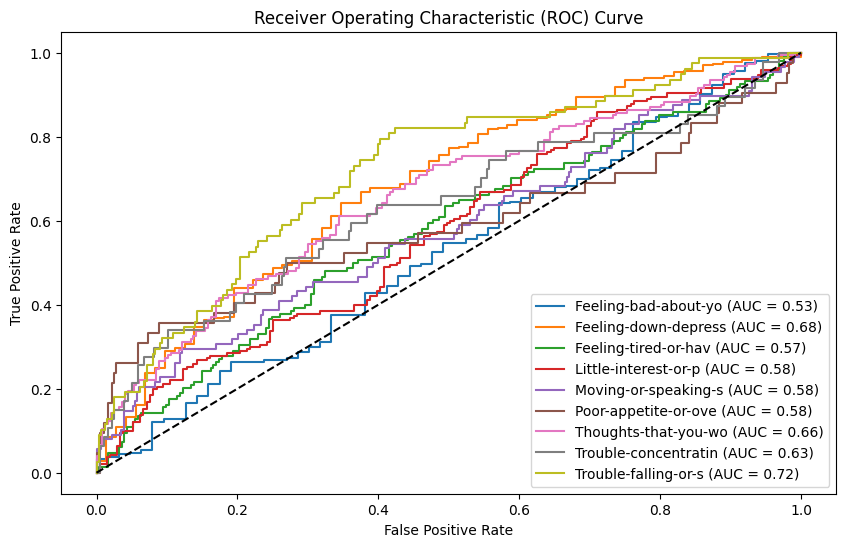

In [108]:
from sklearn.metrics import roc_curve

# Calculate the false positive rate, true positive rate, and thresholds for each label
fpr = dict()
tpr = dict()
thresholds = dict()
for i, label in enumerate(mlb.classes_):
    fpr[label], tpr[label], thresholds[label] = roc_curve(y_test[:, i], y_pred[:, i])

# Plot the ROC curve for each label
plt.figure(figsize=(10, 6))
for label in mlb.classes_:
    plt.plot(fpr[label], tpr[label], label=f'{label[:20]} (AUC = {roc_auc_scores[label]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [109]:
sample_text_index = 11  # 12th row in zero-indexed Python
sample_text_prediction = model.predict(X_test[sample_text_index:sample_text_index+1])
predicted_labels = (sample_text_prediction > 0.5).astype(int)
print(mlb.inverse_transform(predicted_labels))


1/1 [==============================] - 0s 24ms/step
[('Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down', 'Feeling-down-depressed-or-hopeless')]


In [110]:
y_test[sample_text_index:sample_text_index+1]

array([[1, 1, 1, 0, 0, 0, 1, 0, 1]])

In [111]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test)
# Convert predictions to binary format
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy:", accuracy)

13/13 [==============================] - 0s 2ms/step


Accuracy: 0.08728179551122195


In [112]:
(y_test == binary_predictions)

array([[ True,  True, False, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False,  True,  True],
       ...,
       [ True,  True, False, ..., False,  True,  True],
       [ True, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [113]:
from sklearn.metrics import average_precision_score

# Calculate the Average Precision (AP) for each class
ap_scores = []
for i in range(len(labels)):
    true_label = y_test[:, i]
    predicted_prob = binary_predictions[:, i]
    ap = average_precision_score(true_label, predicted_prob, average='weighted')
    ap_scores.append(ap)

# Calculate the Mean Average Precision (MAP)
map_score = sum(ap_scores) / len(ap_scores)

print("Mean Average Precision (MAP):", map_score)


Mean Average Precision (MAP): 0.40133038118896547
